In [1]:
from src.simgraph import calc_simgraph
import src.spectral_utils as su
import src.graph_utils as gu
import src.localization as localization
import numpy as np

import matplotlib.pyplot as plt

In [2]:
#For some setups its neccessary to allow tensorflow to allocate gpu memory
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
f1 = './testimages/splicing-01.TIF' #spliced image
#gt = 

fweights = './models/cam_128/-30' #path to model CNN weights
patch_size = 128 #patch size, must match associated weights file
overlap = 96 #patch sampling overlap

In [4]:
#compute forensic similarity graphs for the spliced image
I1 = plt.imread(f1)[:,:,:3]
sg1 = calc_simgraph(image = I1,
                    f_weights_restore = fweights, patch_size = patch_size,
                    overlap = overlap)





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.



INFO:tensorflow:Restoring parameters from ./models/cam_128/-30


100%|██████████| 2745/2745 [00:11<00:00, 230.52it/s]


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

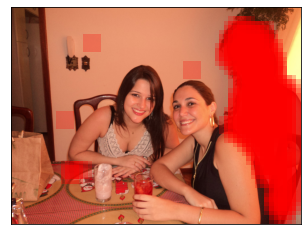

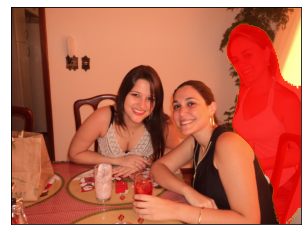

In [5]:
## Forgery Localization - Modularity Optimization
M = gu.sym_mat(sg1.mat) #symmetric similarity matrix for spliced image
g = gu.adj_to_graph(M, threshold=0.7) #convert to igraph Graph object
com, n, mod = gu.cluster_fastgreedy(g,n=2,weighted=True) #compute modularity

pat_loc = localization.PatchLocalization(inds = sg1.inds, patch_size = patch_size,
                                        prediction = com.membership)

f = pat_loc.plot_heatmap(image=I1)

pix_loc = localization.pixel_loc_from_patch_pred(prediction=pat_loc.prediction,
                                                 inds = sg1.inds,
                                                 patch_size = patch_size,
                                                 image_shape = I1.shape[:2],
                                                 threshold = 0.5)


#pat_loc.pixel_mask()
pix_loc.plot(image=I1)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

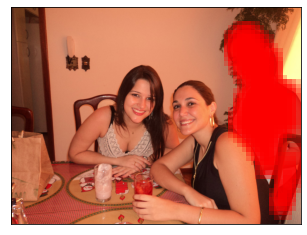

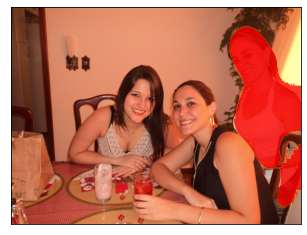

In [6]:
## Forgery Localization - Spectral Clustering
L = su.laplacian(M)
prediction = su.spectral_cluster(L)

pat_loc = localization.PatchLocalization(inds = sg1.inds, patch_size = patch_size,
                                        prediction = prediction)

f = pat_loc.plot_heatmap(image=I1,label=0)
#here we flip the label for easier visualization..
#note the label=0 in the line above (default=1)
#and the ~pat_loc.prediction in the line below
pix_loc = localization.pixel_loc_from_patch_pred(prediction=~pat_loc.prediction,
                                                 inds = sg1.inds,
                                                 patch_size = patch_size,
                                                 image_shape = I1.shape[:2],
                                                 threshold = 0.37)



pix_loc.plot(image=I1)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

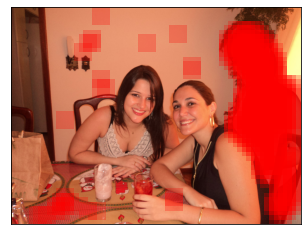

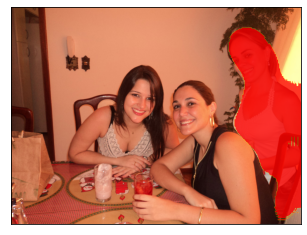

In [7]:
## Forgery Localization - Normalized Spectral Clustering
L = su.laplacian(M,laplacian_type='sym')
#normalization is performed with the laplacian_type parameter (default is None)
#otherwise the analysis is the same

prediction = su.spectral_cluster(L)

pat_loc = localization.PatchLocalization(inds = sg1.inds, patch_size = patch_size,
                                        prediction = ~prediction)
f = pat_loc.plot_heatmap(image=I1,label=0)
#here we flip the label for easier visualization..
#note the label=0 in the line above
#and the ~pat_loc.prediction in the line below
pix_loc = localization.pixel_loc_from_patch_pred(prediction=~pat_loc.prediction,
                                                 inds = sg1.inds,
                                                 patch_size = patch_size,
                                                 image_shape = I1.shape[:2],
                                                 threshold = 0.5)

pix_loc.plot(image=I1)